In [1]:
import os
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import xarray as xr
import numpy as np
import yaml
from credit.losses import load_loss
from credit.transforms import Normalize_ERA5_and_Forcing
from credit.parser import credit_main_parser
from credit.models.unet import SegmentationModel
from credit.models.crossformer import CrossFormer
from credit.postblock import PostBlock
from credit.models import load_model
from credit.datasets.load_dataset_and_dataloader import load_dataset
from credit.datasets.load_dataset_and_dataloader import BatchForecastLenDataLoader
from credit.datasets import setup_data_loading
from credit.datasets.era5_multistep_batcher import Predict_Dataset_Batcher
from credit.ensemble.bred_vector import (
    clone_dataset,
    generate_bred_vectors_cycle,
    adjust_start_times,
)
from credit.forecast import load_forecasts
from credit.transforms import load_transforms
from credit.data import concat_and_reshape, reshape_only

from credit.ensemble.spherical import SphericalNoise
import warnings
warnings.filterwarnings("ignore")

In [2]:
filepath = "/glade/derecho/scratch/schreck/CREDIT_runs/ensemble/single_step/bred_vectors"

with open(os.path.join(filepath, "model.yml"), "r") as f:
    conf = yaml.safe_load(f)
conf = credit_main_parser(conf, parse_training=False, parse_predict=True, print_summary=False)
data_config = setup_data_loading(conf)

In [3]:
from credit.models import load_model

model = load_model(conf).to("cuda")

model.load_state_dict(torch.load(os.path.join(filepath, "checkpoint.pt"))['model_state_dict'])

model = model.eval()

In [4]:
from typing import Callable, Optional
from collections import OrderedDict


def hemi_rescale(perturbation, latitudes, north_scale=1.0, south_scale=1.0):
    """
    Linearly interpolate scaling in tropics between 20S and 20N.

    Args:
        latitudes: Tensor of shape (H,) from +90 to -90
    """
    device = perturbation.device
    latitudes = latitudes.to(device)
    weights = torch.ones_like(latitudes)

    for i, lat in enumerate(latitudes):
        if lat >= 20:
            weights[i] = north_scale
        elif lat <= -20:
            weights[i] = south_scale
        else:
            frac = (lat + 20) / 40  # Maps [-20, 20] to [0, 1]
            weights[i] = (1 - frac) * south_scale + frac * north_scale

    weights = weights.view(1, 1, 1, -1, 1)
    return perturbation * weights

In [5]:
class BredVector:
    def __init__(
        self,
        model: Callable[[torch.Tensor], torch.Tensor],
        noise_amplitude: float = 0.15,
        num_cycles: int = 5,
        integration_steps: int = 1,
        perturbation_method: Optional[Callable[[torch.Tensor, OrderedDict[str, np.ndarray]], torch.Tensor]] = None,
        hemispheric_rescale: Optional[Callable[[torch.Tensor, torch.Tensor], torch.Tensor]] = None,
        terrain_file: str = None,
        perturb_channel_idx: int = None,
        ensemble_perturb: bool = False,
        clamp: bool = False,
        clamp_min: float = None,
        clamp_max: float = None,
        input_static_dim: int = 3,
        varnum_diag: int = 0,
        post_conf: dict = {},
    ):
        self.model = model
        self.noise_amplitude = noise_amplitude
        self.num_cycles = num_cycles
        self.integration_steps = integration_steps
        self.perturbation_method = perturbation_method  # e.g., Brown()
        self.hemispheric_rescale = hemi_rescale if hemispheric_rescale else False
        self.ensemble_perturb = ensemble_perturb
        self.perturb_channel_idx = perturb_channel_idx
        self.clamp = clamp
        self.clamp_min = clamp_min
        self.clamp_max = clamp_max
        self.input_static_dim = input_static_dim
        self.varnum_diag = varnum_diag
        self.post_conf = post_conf

        self.flag_mass_conserve = False
        self.flag_water_conserve = False
        self.flag_energy_conserve = False

        self.use_post_block = False
        if post_conf.get("activate", False):
            if post_conf["global_mass_fixer"]["activate"]:
                if post_conf["global_mass_fixer"]["activate_outside_model"]:
                    logger.info("Activate GlobalMassFixer outside of model")
                    self.flag_mass_conserve = True
                    self.opt_mass = GlobalMassFixer(post_conf)

            if post_conf["global_water_fixer"]["activate"]:
                if post_conf["global_water_fixer"]["activate_outside_model"]:
                    logger.info("Activate GlobalWaterFixer outside of model")
                    self.flag_water_conserve = True
                    self.opt_water = GlobalWaterFixer(post_conf)

            if post_conf["global_energy_fixer"]["activate"]:
                if post_conf["global_energy_fixer"]["activate_outside_model"]:
                    logger.info("Activate GlobalEnergyFixer outside of model")
                    self.flag_energy_conserve = True
                    self.opt_energy = GlobalEnergyFixer(post_conf)
            self.use_post_block = True

        if self.use_post_block:
            # freeze base model weights before postblock init
            if "skebs" in post_conf.keys():
                if post_conf["skebs"].get("activate", False) and post_conf["skebs"].get(
                    "freeze_base_model_weights", False
                ):
                    # logger.warning("freezing all base model weights due to skebs config")
                    for param in self.parameters():
                        param.requires_grad = False

            # logger.info("using postblock")
            self.postblock = PostBlock(self.post_conf)

        if self.hemispheric_rescale is not None:
            if not os.path.exists(terrain_file) or terrain_file is None:
                raise FileNotFoundError(f"Terrain file {terrain_file} not found")
            latlons = xr.open_dataset(terrain_file).load()
            self.latitudes = torch.tensor(latlons.latitude.values)

    def perturb(self, x_input: torch.Tensor, forecast_step: int = 1) -> torch.Tensor:
        x = x_input.clone()
        device = x.device

        if hasattr(self.noise_amplitude, "__len__"):
            # Vector case: create full tensor with 1s for static channels
            static_ones = torch.ones(self.input_static_dim, device=device, dtype=x.dtype)
            dynamic_amp = torch.tensor(self.noise_amplitude, device=device, dtype=x.dtype)
            noise_amp_full = torch.cat([static_ones, dynamic_amp]).view(1, -1, 1, 1)
            noise_amp_dynamic = dynamic_amp.view(1, -1, 1, 1, 1)  # Same length as dynamic channels
        else:
            # Scalar case
            noise_amp_full = self.noise_amplitude
            noise_amp_dynamic = self.noise_amplitude

        # Add structured noise (Z500-only or full depending on step)
        if self.perturbation_method is not None:
            delta_x0 = self.perturbation_method(x)
        else:
            delta_x0 = noise_amp_full * torch.randn_like(x)

        if forecast_step == 1 and self.perturb_channel_idx is not None:
            # Only perturb Z500 (channel index 66)
            z500_idx = self.perturb_channel_idx
            mask = torch.zeros_like(delta_x0)
            mask[:, z500_idx, ...] = 1.0
            delta_x0 *= mask

        x_perturbed = x + delta_x0

        if self.clamp:
            x = torch.clamp(x, self.clamp_min, self.clamp_max)
            x_perturbed = torch.clamp(x_perturbed, self.clamp_min, self.clamp_max)

        # Initialize based on NVIDIA pattern, using your existing variables
        x_current = x  # This is 'x' in NVIDIA code (your unperturbed state with static channels)
        # Extract the dynamic perturbation from the initial delta_x0
        # Only dynamic channels get perturbed, static channels are preserved
        dx = delta_x0[:, : -self.input_static_dim, ...]  # Initial perturbation

        for k in range(self.integration_steps):
            # x1 = x + dx (apply current perturbation to dynamic channels only)
            # Dynamic channels are first, static channels are last in input
            x_perturbed_dyn = x_current[:, : -self.input_static_dim, ...] + dx
            if self.clamp:
                x_perturbed_dyn = torch.clamp(x_perturbed_dyn, self.clamp_min, self.clamp_max)
            # Reconstruct full state (dynamic first, then static channels unchanged)
            x1 = torch.cat([x_perturbed_dyn, x_current[:, -self.input_static_dim :, ...]], dim=1)

            # x2, _ = self.model(x1, coords)
            # Model outputs ONLY dynamic channels (no static channels)
            x2 = self.model(x1.to(x.dtype))

            # Calculate what NVIDIA calls 'xd' (the unperturbed prediction)
            # Model outputs ONLY dynamic channels (no static channels)
            xd = self.model(x_current.to(x.dtype))

            if self.ensemble_perturb:  # This matches NVIDIA's ensemble_perturb flag
                # dx1 = x2 - xd
                # Both x2 and xd are model outputs with only dynamic channels
                dx1 = x2 - xd

                # dx = dx1 + self.noise_amplitude * (dx - dx.mean(dim=0))
                dx = dx1 + noise_amp_dynamic * (dx - dx.mean(dim=0))
            else:
                # dx = x2 - xd
                # Both x2 and xd are model outputs with only dynamic channels
                dx = x2 - xd

            # Apply your specific modifications (channel-specific gamma scaling during loop)
            if forecast_step == 1 and self.perturb_channel_idx is not None:
                z500_idx = self.perturb_channel_idx
                # x_dyn uses the input channels (includes static), but z500_idx is absolute
                x_dyn = x_current[:, z500_idx : z500_idx + 1, ...]
                # dx_z500 uses model output indexing (only dynamic channels)
                dx_z500 = dx[:, z500_idx : z500_idx + 1, ...]
                x_perturbed_dyn_subset = x_dyn + dx_z500
                gamma = torch.norm(x_dyn) / (torch.norm(x_perturbed_dyn_subset) + 1e-8)
                # Apply gamma to the specific channel perturbation in model output space
                dx[:, z500_idx : z500_idx + 1, ...] *= gamma
            else:
                # For full perturbation, compare input dynamic vs model output + perturbation
                x_dyn = x_current[:, : -self.input_static_dim, ...]
                x_perturbed_dyn_subset = x_dyn + dx
                gamma = torch.norm(x_dyn) / (torch.norm(x_perturbed_dyn_subset) + 1e-8)
                dx = dx * gamma

            if self.hemispheric_rescale is not None:
                latitudes = torch.tensor(np.linspace(90, -90, x.shape[-2])).to(device)
                dx = self.hemispheric_rescale(dx, latitudes)

            # Update x for next iteration - but x_current needs to keep static channels
            # So we reconstruct it from the model prediction + static channels
            x_current = torch.cat([xd, x_current[:, -self.input_static_dim :, ...]], dim=1)

        # Apply NVIDIA's final gamma scaling and return the final perturbation
        if forecast_step == 1 and self.perturb_channel_idx is not None:
            z500_idx = self.perturb_channel_idx
            # Use input space for x_final (includes static channels)
            x_final = x_current[:, z500_idx : z500_idx + 1, ...]
            # Use model output space for dx_z500 (only dynamic channels)
            dx_z500 = dx[:, z500_idx : z500_idx + 1, ...]
            x_plus_dx = x_final + dx_z500
            gamma_final = torch.norm(x_final) / (torch.norm(x_plus_dx) + 1e-8)
            # Create full perturbation tensor in model output space (only dynamic channels)
            delta_x_final = torch.zeros_like(dx)

            if isinstance(noise_amp_dynamic, torch.Tensor) and noise_amp_dynamic.ndim > 0:
                scale = noise_amp_dynamic[0, z500_idx, 0, 0, 0]
            else:
                scale = noise_amp_dynamic  # assumed to be a scalar (float or 0-dim tensor)

            delta_x_final[:, z500_idx : z500_idx + 1, ...] = dx_z500 * scale * gamma_final

            return delta_x_final.detach()
        else:
            # Use input space for x_final (dynamic channels only)
            x_final = x_current[:, : -self.input_static_dim, ...]
            x_plus_dx = x_final + dx
            gamma_final = torch.norm(x_final) / (torch.norm(x_plus_dx) + 1e-8)
            return (dx * noise_amp_dynamic * gamma_final).detach()

    def __call__(self, initial_condition: torch.Tensor, dataset, return_delta_x=False) -> list[torch.Tensor]:
        device = initial_condition.device

        bred_vectors, delta_x_vectors = [], []
        with torch.no_grad():
            for _ in range(self.num_cycles):
                # Make a copy of the dataloader
                dataset_c = clone_dataset(dataset)
                data_loader = BatchForecastLenDataLoader(dataset_c)

                # model inference loop
                for _, batch in enumerate(data_loader):
                    forecast_step = batch["forecast_step"].item()

                    # Initial input processing
                    if forecast_step == 1:
                        if "x_surf" in batch:
                            x = concat_and_reshape(batch["x"], batch["x_surf"]).to(device).float()
                        else:
                            x = reshape_only(batch["x"]).to(device).float()

                        # Add forcing and static variables
                        if "x_forcing_static" in batch:
                            x_forcing_batch = batch["x_forcing_static"].to(device).permute(0, 2, 1, 3, 4).float()
                            x = torch.cat((x, x_forcing_batch), dim=1)

                        # Clamp if needed
                        if self.clamp:
                            x = torch.clamp(x, min=self.clamp_min, max=self.clamp_max)

                    else:
                        # Add current forcing and static variables
                        if "x_forcing_static" in batch:
                            x_forcing_batch = batch["x_forcing_static"].to(device).permute(0, 2, 1, 3, 4).float()
                            x = torch.cat((x, x_forcing_batch), dim=1)

                        # Clamp if needed
                        if self.clamp:
                            x = torch.clamp(x, min=self.clamp_min, max=self.clamp_max)

                    # Load y-truth
                    if "y_surf" in batch:
                        y = concat_and_reshape(batch["y"], batch["y_surf"]).to(device).float()
                    else:
                        y = reshape_only(batch["y"]).to(device).float()

                    if "y_diag" in batch:
                        y_diag_batch = batch["y_diag"].to(device).permute(0, 2, 1, 3, 4)
                        y = torch.cat((y, y_diag_batch), dim=1).to(device).float()

                    # Compute bred vector
                    delta_x = self.perturb(x, forecast_step=forecast_step)

                    # Stop here if we are done
                    if batch["stop_forecast"].item():
                        break

                    # Add the perturbation to the model input
                    x[:, : delta_x.shape[1], :, :, :] += delta_x

                    # Pass through the model to advance one time step
                    y_pred = self.model(x)

                    # backup init state
                    if self.flag_mass_conserve:
                        if forecast_step == 1:
                            x_init = x.clone()

                    # mass conserve using initialization as reference
                    if self.flag_mass_conserve:
                        input_dict = {"y_pred": y_pred, "x": x_init}
                        input_dict = self.opt_mass(input_dict)
                        y_pred = input_dict["y_pred"]

                    # water conserve use previous step output as reference
                    if self.flag_water_conserve:
                        input_dict = {"y_pred": y_pred, "x": x}
                        input_dict = self.opt_water(input_dict)
                        y_pred = input_dict["y_pred"]

                    # energy conserve use previous step output as reference
                    if self.flag_energy_conserve:
                        input_dict = {"y_pred": y_pred, "x": x}
                        input_dict = self.opt_energy(input_dict)
                        y_pred = input_dict["y_pred"]

                    if dataset.history_len == 1:
                        if "y_diag" in batch:
                            x = y_pred[:, : -self.varnum_diag, ...].detach()
                        else:
                            x = y_pred.detach()
                    else:
                        if self.static_dim_size == 0:
                            x_detach = x[:, :, 1:, ...].detach()
                        else:
                            x_detach = x[:, : -self.static_dim_size, 1:, ...].detach()

                        if "y_diag" in batch:
                            x = torch.cat([x_detach, y_pred[:, : -self.varnum_diag, ...].detach()], dim=2)
                        else:
                            x = torch.cat([x_detach, y_pred.detach()], dim=2)

                for sign in [+1, -1]:
                    x0 = initial_condition.clone()
                    x0[:, self.input_static_dim :, ...] += sign * delta_x.detach()

                    if self.use_post_block:
                        x0 = self.postblock(
                            {
                                "y_pred": x0,
                                "x": initial_condition,
                            }
                        )

                    # Apply physical conservation laws
                    if self.flag_mass_conserve:
                        input_dict = {"y_pred": x0, "x": initial_condition}
                        x0 = self.opt_mass(input_dict)["y_pred"]

                    if self.flag_water_conserve:
                        input_dict = {"y_pred": x0, "x": initial_condition}
                        x0 = self.opt_water(input_dict)["y_pred"]

                    if self.flag_energy_conserve:
                        input_dict = {"y_pred": x0, "x": initial_condition}
                        x0 = self.opt_energy(input_dict)["y_pred"]

                    bred_vectors.append(x0)

                    delta_x_vectors.append(sign * delta_x.detach())

        if return_delta_x:
            return bred_vectors, delta_x_vectors

        return bred_vectors


In [6]:
rmse_at_48_hours = np.sqrt(np.array([
    0.1612, 0.1582, 0.1438, 0.1462, 0.1662, 0.1593, 0.1210, 0.1116, 0.1143,
    0.1212, 0.1247, 0.1225, 0.1030, 0.0974, 0.0988, 0.0992, 0.1115, 0.1267,
    0.1202, 0.1247, 0.1466, 0.1409, 0.1018, 0.0935, 0.0958, 0.1023, 0.1068,
    0.1066, 0.0906, 0.0899, 0.0920, 0.0924, 0.1609, 0.1507, 0.1477, 0.1525,
    0.1609, 0.1260, 0.1092, 0.1082, 0.0995, 0.1021, 0.1059, 0.1105, 0.1031,
    0.0880, 0.0724, 0.0668, 0.0538, 0.1163, 0.0879, 0.1079, 0.1910, 0.1612,
    0.1635, 0.1700, 0.1624, 0.1599, 0.1599, 0.1585, 0.1480, 0.1405, 0.1366,
    0.1359, 0.0797, 0.0609, 0.0965, 0.1158, 0.0979, 0.0710, 0.1609
]))

amplitude_vector = 2.0 * np.abs(np.array(rmse_at_48_hours)) # 3.5

In [7]:
amplitude_vector

array([0.8029944 , 0.79548727, 0.75841941, 0.76472217, 0.81535268,
       0.79824808, 0.69570109, 0.66813172, 0.67616566, 0.69627581,
       0.70625774, 0.7       , 0.64187226, 0.62417946, 0.62864935,
       0.62992063, 0.66783231, 0.71189887, 0.69339743, 0.70625774,
       0.76576759, 0.75073298, 0.63812225, 0.61155539, 0.6190315 ,
       0.63968742, 0.65360539, 0.65299311, 0.60199668, 0.59966657,
       0.60663004, 0.60794737, 0.80224684, 0.77640196, 0.76863515,
       0.78102497, 0.80224684, 0.70992957, 0.66090847, 0.65787537,
       0.63087241, 0.63906181, 0.6508456 , 0.66483081, 0.64218377,
       0.59329588, 0.53814496, 0.51691392, 0.46389654, 0.68205572,
       0.59295868, 0.65696271, 0.87407094, 0.8029944 , 0.80870266,
       0.82462113, 0.80597767, 0.79974996, 0.79974996, 0.79624117,
       0.76941536, 0.74966659, 0.73918874, 0.73729234, 0.56462377,
       0.49355851, 0.62128898, 0.68058798, 0.62577951, 0.5329165 ,
       0.80224684])

In [8]:
amplitude_vector = amplitude_vector
amplitude_vector_spherical = amplitude_vector

padding_conf = {
   "activate": True,
   "mode": "earth", 
   "pad_lat": [160, 160],    # (256-192)/2 = 32
   "pad_lon": [112, 112]    # (512-288)/2 = 112
}
noise = SphericalNoise(amplitude=amplitude_vector_spherical, padding_conf=padding_conf)

bred = BredVector(
    model=model,
    perturbation_method=noise,
    noise_amplitude=amplitude_vector,
    perturb_channel_idx=69, # Z500
    num_cycles=1,
    hemispheric_rescale=hemi_rescale,
    terrain_file=conf["loss"]["latitude_weights"],
    integration_steps=20,
    clamp=False,
    post_conf=conf["model"]["post_conf"]
)

In [9]:
bred_time_lag = 48
lead_time_periods = conf["data"]["lead_time_periods"]


dataset = Predict_Dataset_Batcher(
    varname_upper_air=data_config["varname_upper_air"],
    varname_surface=data_config["varname_surface"],
    varname_dyn_forcing=data_config["varname_dyn_forcing"],
    varname_forcing=data_config["varname_forcing"],
    varname_static=data_config["varname_static"],
    varname_diagnostic=data_config["varname_diagnostic"],
    filenames=data_config["all_ERA_files"],
    filename_surface=data_config["surface_files"],
    filename_dyn_forcing=data_config["dyn_forcing_files"],
    filename_forcing=data_config["forcing_files"],
    filename_static=data_config["static_files"],
    filename_diagnostic=data_config["diagnostic_files"],
    fcst_datetime=load_forecasts(conf),
    lead_time_periods=lead_time_periods,
    history_len=data_config["history_len"],
    skip_periods=data_config["skip_periods"],
    transform=load_transforms(conf),
    sst_forcing=data_config["sst_forcing"],
    batch_size=1,
    rank=0,
    world_size=1,
)

dataset_bred_vector = Predict_Dataset_Batcher(
    varname_upper_air=data_config["varname_upper_air"],
    varname_surface=data_config["varname_surface"],
    varname_dyn_forcing=data_config["varname_dyn_forcing"],
    varname_forcing=data_config["varname_forcing"],
    varname_static=data_config["varname_static"],
    varname_diagnostic=data_config["varname_diagnostic"],
    filenames=data_config["all_ERA_files"],
    filename_surface=data_config["surface_files"],
    filename_dyn_forcing=data_config["dyn_forcing_files"],
    filename_forcing=data_config["forcing_files"],
    filename_static=data_config["static_files"],
    filename_diagnostic=data_config["diagnostic_files"],
    fcst_datetime=adjust_start_times(
        load_forecasts(conf), hours=bred_time_lag
    ),
    lead_time_periods=lead_time_periods,
    history_len=data_config["history_len"],
    skip_periods=data_config["skip_periods"],
    transform=load_transforms(conf),
    sst_forcing=data_config["sst_forcing"],
    batch_size=1,
    rank=0,
    world_size=1,
)

device = "cuda"
batch = dataset.__getitem__(0)

In [10]:
if "x_surf" in batch:
    x = concat_and_reshape(batch["x"], batch["x_surf"]).to(device).float()
else:
    x = reshape_only(batch["x"]).to(device).float()

# Add forcing and static variables
if "x_forcing_static" in batch:
    x_forcing_batch = batch["x_forcing_static"].to(device).permute(0, 2, 1, 3, 4).float()
    x = torch.cat((x, x_forcing_batch), dim=1)

In [11]:
bred_ics = bred(x, dataset_bred_vector)

In [12]:
# bred_ics[0]

In [13]:
from credit.transforms import Normalize_ERA5_and_Forcing
transformer = Normalize_ERA5_and_Forcing(conf)

In [14]:
x = transformer.inverse_transform(x)
bv = transformer.inverse_transform(bred_ics[1])

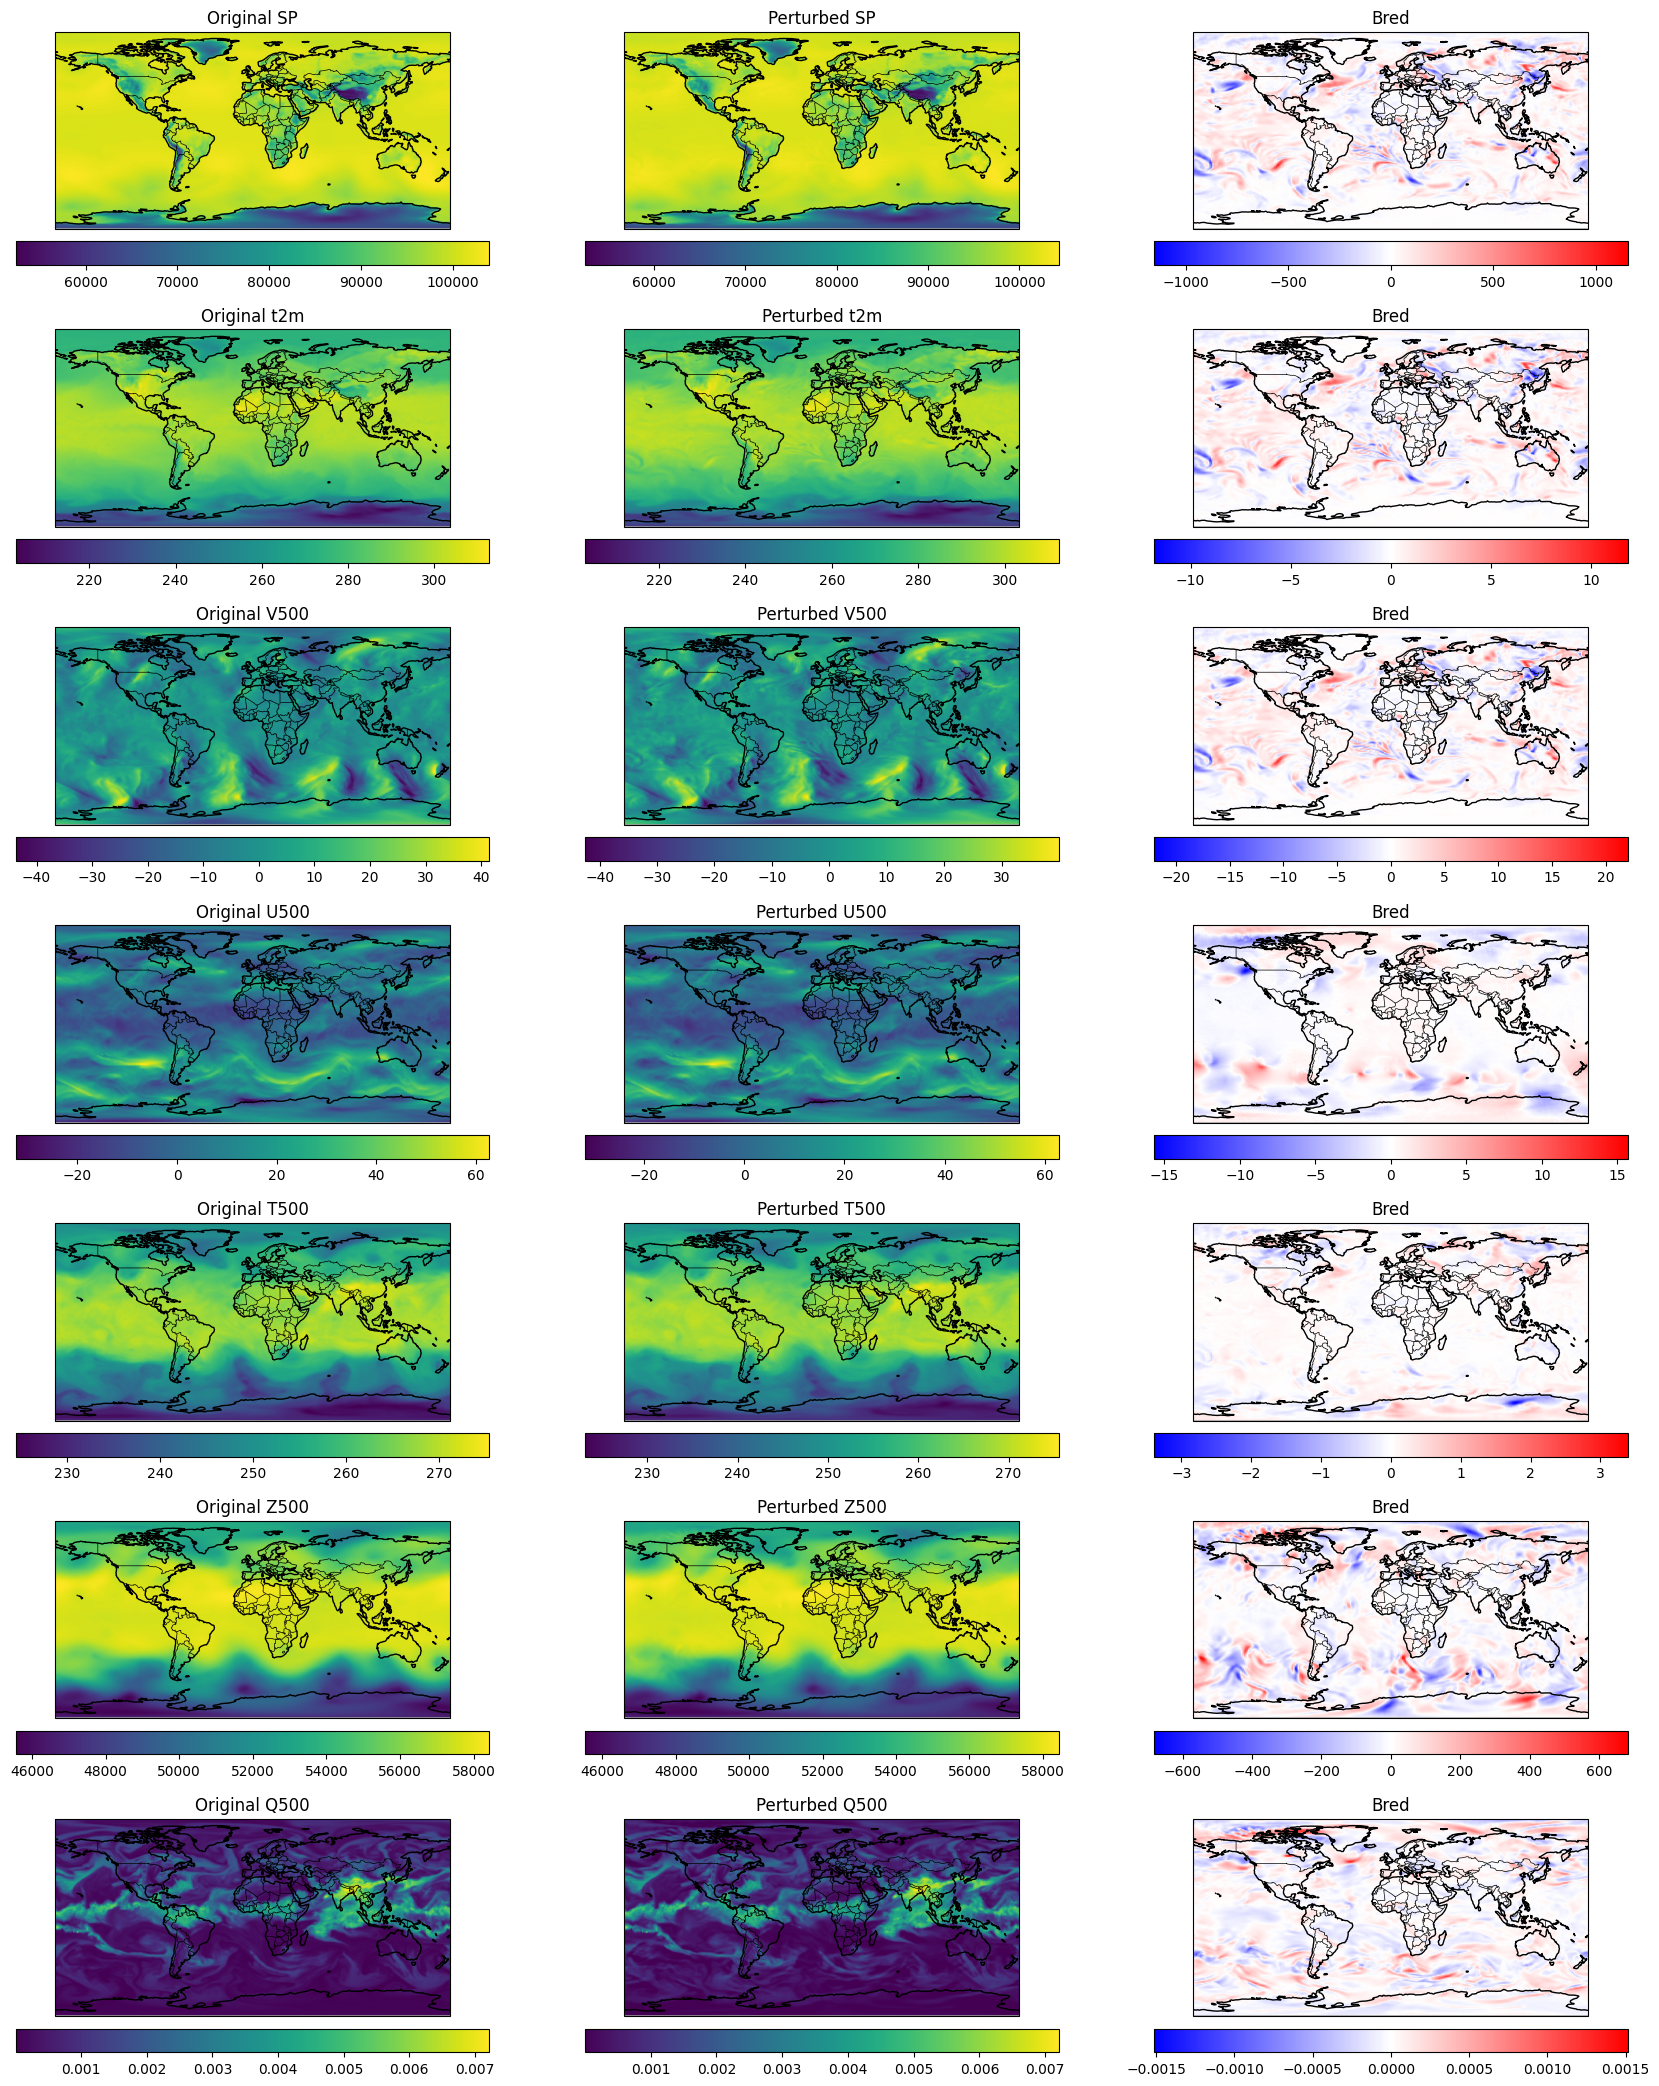

In [15]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

proj = ccrs.PlateCarree(central_longitude=0)

levels = 16
variables = ["U", "V", "T", "Q"]
surface_variables = ['SP', 't2m', 'V500', 'U500', 'T500', 'Z500', 'Q500']
all_vars = [f"{var}_{i}" for var in variables for i in range(levels)] + surface_variables

fig, axs = plt.subplots(len(surface_variables), 3, figsize=(18, 3 * len(surface_variables)),
                        subplot_kw={'projection': proj})
plt.subplots_adjust(wspace=0.005, hspace=0.3)

for i, var in enumerate(surface_variables):
    idx = 4 * levels + i  # Index in the full variable stack
    x_z500 = x[0][idx].squeeze(0).cpu()
    bred_z500 = bv[0][idx].squeeze(0).cpu()
    diff_z500 = bred_z500 - x_z500

    titles = [f'Original {var}', f'Perturbed {var}', 'Bred']
    fields = [x_z500, bred_z500, diff_z500]
    cmaps = ['viridis', 'viridis', 'bwr']
    vmins = [None, None, -diff_z500.abs().max()]
    vmaxs = [None, None, diff_z500.abs().max()]

    for j in range(3):
        ax = axs[i, j]
        im = ax.imshow(fields[j], transform=proj, cmap=cmaps[j], vmin=vmins[j], vmax=vmaxs[j],
                       extent=[0, 360, -90, 90], origin='upper')
        ax.coastlines()
        ax.set_title(titles[j])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.add_feature(cfeature.BORDERS, linewidth=0.5)
        ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.3)
        plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.05, shrink=0.75)

plt.tight_layout()
plt.savefig('surface_variables.png', dpi=300, bbox_inches='tight')
plt.show()
